In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import torch   
import matplotlib.pyplot as plt
import re
import torch.nn as nn
import seaborn as sns
import nltk

from collections import Counter
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from nltk.stem import PorterStemmer
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('./data/train_data.csv')  # read in training data
valid_data = pd.read_csv('./data/valid_data.csv')  # read in validation data
test_data = pd.read_csv('./data/test_data.csv')  # read in test data
# reported score will be based on model performance on test data 

In [5]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [6]:
train_data['Domain'].value_counts()

Domain
Medical         8524
Psychology      2923
CS              2700
ECE             2302
Civil           1787
MAE             1364
Name: count, dtype: int64

In [7]:
class Config:
    batch_size = 64
    learning_rate = 0.0015
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 10 # increase as needed

In [8]:
def to_numpy(x):
    return x.cpu().numpy()

In [9]:
print(f'Shape of Train Dataset: {train_data.shape}')
print(f'Shape of Validation Dataset: {valid_data.shape}')
print(f'Shape of Testing Dataset: {test_data.shape}')
print('--'*20)
print(f'Column Names: {train_data.columns.tolist()}')
print('--'*20)
print(f'Missing Values: \n{train_data.isnull().sum()}')

Shape of Train Dataset: (19600, 3)
Shape of Validation Dataset: (12000, 3)
Shape of Testing Dataset: (8400, 3)
----------------------------------------
Column Names: ['Y1', 'Domain', 'Abstract']
----------------------------------------
Missing Values: 
Y1          0
Domain      0
Abstract    0
dtype: int64


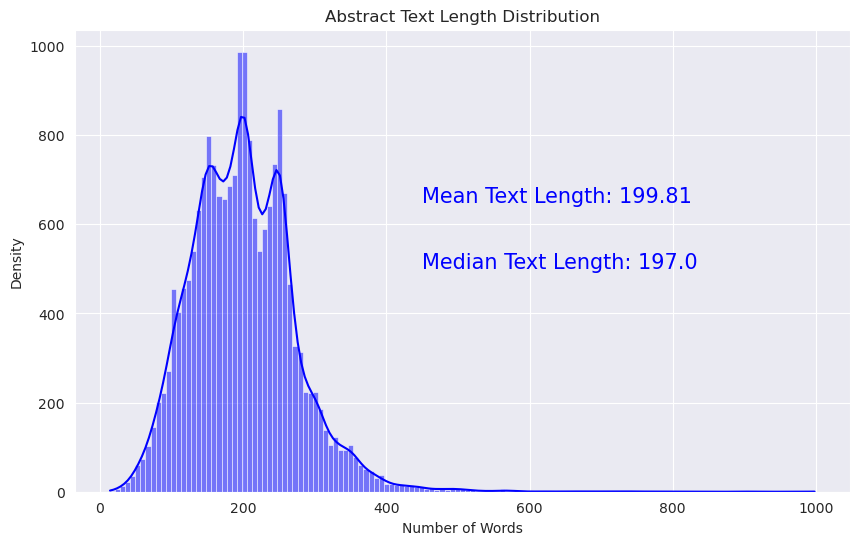

In [10]:
text_lengths = train_data['Abstract'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.histplot(text_lengths, kde=True, color='blue')
plt.title('Abstract Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.text(450, 650, f'Mean Text Length: {np.round(np.mean(text_lengths),2)}', fontsize = 15, color='blue')
plt.text(450, 500, f'Median Text Length: {np.median(text_lengths)}', fontsize = 15, color='blue')
plt.show()

In [11]:
# function to preprocess our text
def preprocess_text(col, stop_words, stemmer):
    """
    Arguments:
    1. col to preprocess
    2. list of stop_words
    3. word stemmer

    steps: tokenize -> lower case ->
            remove stop words -> stem
    """
    col = re.sub(r"[^a-zA-Z0-9 ]", "", col) # keep only letters and numbers 
    tokenize = col.split() # word tokenize 
    lower_case = [word.lower() for word in tokenize] # lower case everything 
    remove_stop_words = [word for word in lower_case if word not in stop_words] 
    stemmed_words = [stemmer.stem(word) for word in remove_stop_words]
    result = " ".join(stemmed_words)
    return result

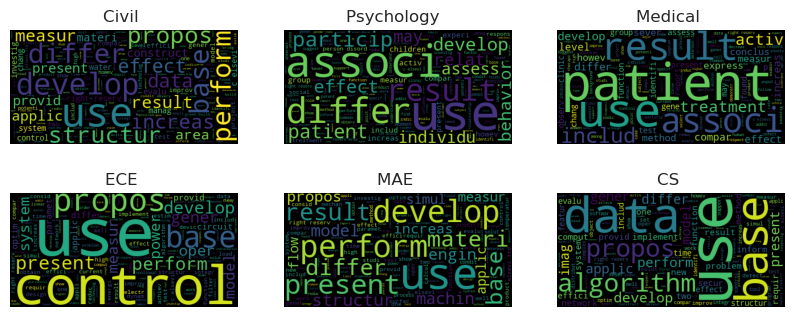

In [12]:
# Define the domains based on the 'Domain' column of the train_data DataFrame
domains = set(train_data['Domain'])

# Load stopwords and stemmer for text preprocessing
stop_words = set(stopwords.words("english"))
extra_stop_words = {"study", "paper", "research", "approach", "analysis", "method", "technique", "process", "system", "design", "case", "model", "use", "effect"}
stop_words = stop_words.union(extra_stop_words)
stemmer = PorterStemmer()
# Define the keyword arguments for the preprocessing function
kwargs = {'stop_words': stop_words,
           'stemmer': stemmer}

# Create the figure with the specified size (width, height)
fig = plt.figure(figsize=(10,6))

# Loop through each domain
for j, domain in enumerate(domains):
    
    # Filter the rows associated with the current domain
    associated_rows = train_data[train_data['Domain'] == domain].reset_index(drop=True)
    
    # Preprocess the 'Abstract' column of the filtered DataFrame
    associated_rows['Abstract'] = associated_rows['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))
    
    # Combine all the preprocessed abstracts into a single string
    all_text = ' '.join(associated_rows['Abstract'])
    
    # Generate the word cloud using the combined text
    word_cloud = WordCloud().generate(all_text)
    
    # Add the word cloud to the figure at the specified position
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(word_cloud)
    
    # Remove the axis for better visualization
    ax.axis('off')
    
    # Set the title for each subplot
    ax.set_title(domain)

# Display the figure
plt.show()

<BarContainer object of 6 artists>

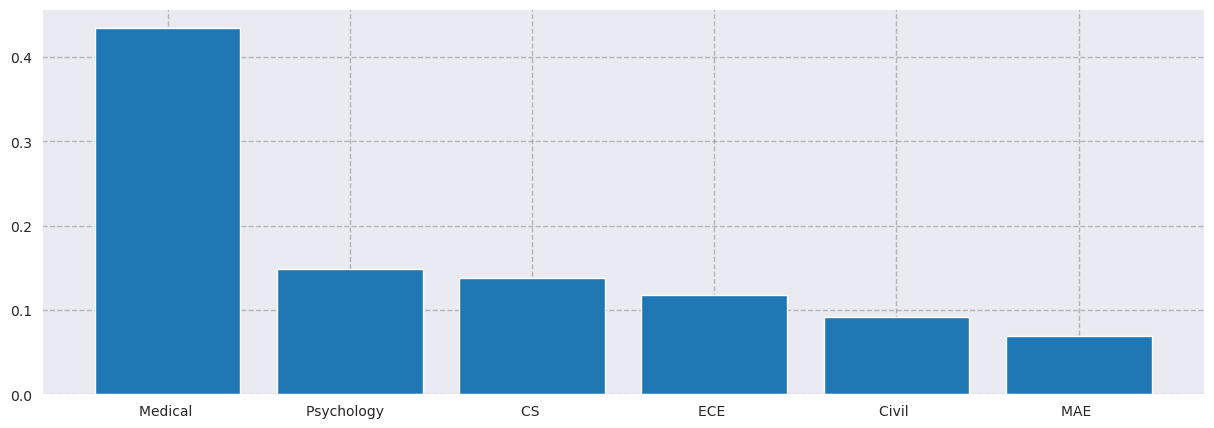

In [13]:
figure = plt.figure(figsize=(15,5))
class_counts = train_data['Domain'].value_counts(normalize=True)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)  # set grid properties
plt.bar(x=class_counts.index, height=class_counts.values)

In [14]:
import pandas as pd
from sklearn.utils import resample
def balance_data(df, target_count):

    balanced_data = pd.DataFrame()  # Initialize dataframe
    domains = df['Domain'].unique()

    for domain_labels in domains:
        domain_df = df[df['Domain'] == domain_labels]  # Filter the dataframe

        if len(domain_df) > target_count:
            class_balanced = resample(domain_df, replace=False, n_samples=target_count, random_state=42) # Undersample
        else:
            class_balanced = resample(domain_df, replace=True, n_samples=target_count, random_state=42) # Oversample

        balanced_data = pd.concat([balanced_data, class_balanced]) # Combine into one dataframe

    return balanced_data


train_data = balance_data(train_data, 5000) #Replaces train_data with the under/oversampled one 
train_data['Domain'].value_counts()

Domain
Medical         5000
MAE             5000
ECE             5000
CS              5000
Psychology      5000
Civil           5000
Name: count, dtype: int64

In [15]:
# apply preprocessing to each df
train_data['Abstract'] = train_data['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))
valid_data['Abstract'] = valid_data['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))
test_data['Abstract_preprocessed'] = test_data['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))

In [16]:
# set up countvectorizer and tfidf 

X_train = train_data['Abstract']
y_train = np.array(train_data['Y1'])

X_val = valid_data['Abstract']
y_val = np.array(valid_data['Y1'])

X_test = test_data['Abstract_preprocessed']
y_test = np.array(test_data['Y1'])

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_val_counts = count_vec.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, X, y, index):
        self.X = X
        self.y = y
        self.index = index
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.index[idx]
    
    
X_train = torch.from_numpy(np.array(X_train_tfidf.todense())).float()
y_train = torch.from_numpy(y_train)
idx_train = torch.from_numpy(np.array(train_data.index))

X_val = torch.from_numpy(np.array(X_val_tfidf.todense())).float()
y_val = torch.from_numpy(y_val)
idx_val = torch.from_numpy(np.array(valid_data.index))

X_test = torch.from_numpy(np.array(X_test_tfidf.todense())).float()
y_test = torch.from_numpy(y_test)
idx_test = torch.from_numpy(np.array(valid_data.index))


train_ds = CustomDataset(X_train, y_train, idx_train)
valid_ds = CustomDataset(X_val, y_val, idx_val)
test_ds = CustomDataset(X_test, y_test, idx_test)

In [18]:
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        # Define Linear Layers
        self.layer1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)

        self.layer2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)  

        self.layer3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)  

        self.layer4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)  

        # New layer with 128 units
        self.layer5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)

        # Output layer
        self.layer6 = nn.Linear(128, num_classes)  

        # Dropout layer
        self.drop = nn.Dropout(0.7)
    
    def forward(self, x):

        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)

        # Dropout
        x = self.drop(x)

        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)

        # Dropout
        x = self.drop(x)

        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)

        # Dropout
        x = self.drop(x)

        # Layer 4
        x = self.layer4(x)
        x = self.bn4(x)
        x = nn.ReLU()(x)

        # New Layer 5
        x = self.layer5(x)
        x = self.bn5(x)
        x = nn.ReLU()(x)

        # Output Layer
        x = self.layer6(x)
        x = nn.Softmax(dim=1)(x)

        return x


## Train Model

In [19]:
def train_model(NeuralNet, train_ds, valid_ds, epochs, learning_rate, batch_size, model_kwargs):
    torch.manual_seed(10)
    model = NeuralNet(**model_kwargs).to(Config.device)
    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    loss_hist_train = []
    loss_hist_val = []
    acc_hist_train = []
    acc_hist_val = []
    f1_hist_train = []
    f1_hist_val = []


    for epoch in range(epochs):
        running_hist_loss = 0.0
        running_hist_acc = 0.0
        running_hist_f1 = 0.0
        lens = 0.0
        model.train()
        num_batches = 0.0
        for x_batch, y_batch, _ in tqdm(train_dl):
            x_batch, y_batch = x_batch.to(Config.device), y_batch.to(Config.device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            running_hist_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            f1_score_calc = f1_score(to_numpy(torch.argmax(pred, dim=1)), to_numpy(y_batch), average='macro')
            running_hist_f1 += f1_score_calc
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            running_hist_acc += is_correct.sum()
            lens += len(x_batch)
            num_batches += 1
        running_hist_acc /= lens
        running_hist_loss /= lens
        running_hist_f1 /= np.ceil(len(train_dl.dataset.X)/batch_size)


        running_hist_loss_test = 0.0
        running_hist_acc_test = 0.0
        running_hist_f1_test = 0.0
        lens = 0.0
        model.eval()
        with torch.no_grad():
            for x, y, _ in tqdm(valid_dl):
                x, y = x.to(Config.device), y.to(Config.device)
                pred = model(x)
                loss = criterion(pred, y)
                running_hist_loss_test += loss.item()
                f1_score_calc = f1_score(to_numpy(torch.argmax(pred, dim=1)), to_numpy(y), average='macro')
                running_hist_f1_test += f1_score_calc
                is_correct = (torch.argmax(pred, dim=1) == y)
                running_hist_acc_test += is_correct.float().sum()
                lens += len(x)

            running_hist_loss_test /= lens
            running_hist_acc_test /= lens
            running_hist_f1_test /= np.ceil(len(valid_dl.dataset.X)/batch_size)
        print(f'Predicted Test: {torch.argmax(pred, dim=1).detach().cpu().numpy()}')
        print(f'Actual Test:    {y.detach().cpu().numpy()}')
        print(f"Epoch {epoch}")
        print("Train Loss: \t{:.4f}".format(running_hist_loss))
        print("Validation Loss: \t{:.4f}".format(running_hist_loss_test))
        print("Train Accuracy: \t{:.3f}".format(running_hist_acc))
        print("Validation Accuracy: \t{:.3f}".format(running_hist_acc_test))
        print("Train F1: \t{:.3f}".format(running_hist_f1))
        print("Validation F1: \t{:.3f}".format(running_hist_f1_test))
        print("------------------------------")

            # save best model based on accuracy
        if (epoch > 1 and running_hist_loss_test < np.min(acc_hist_val)) or epoch == 1:
            torch.save(model.state_dict(), "./models/checkpoint.pt")

        loss_hist_train.append(running_hist_loss)
        loss_hist_val.append(running_hist_loss_test)
        acc_hist_val.append(running_hist_acc_test.detach().cpu().numpy())
        acc_hist_train.append(running_hist_acc.detach().cpu().numpy())
        f1_hist_train.append(running_hist_f1)
        f1_hist_val.append(running_hist_f1_test)

        

        
    # instantiate model and load best weights
    model = NeuralNet(**model_kwargs)
    model.load_state_dict(torch.load("./models/checkpoint.pt"))
    model.eval()

    return model, loss_hist_train, loss_hist_val, acc_hist_train, acc_hist_val, f1_hist_train, f1_hist_val

In [ ]:
kwargs = {'input_size': train_ds.X.shape[1],
          'num_classes': 6}
model, loss_train, loss_val, acc_train, acc_val, f1_train, f1_val = train_model(NeuralNet, train_ds, valid_ds, Config.epochs, Config.learning_rate, 
                                                                            Config.batch_size, kwargs)

NeuralNet(
  (layer1): Linear(in_features=76795, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer6): Linear(in_features=128, out_features=6, bias=True)
  (drop): Dropout(p=0.7, inplace=False)
)


100%|██████████| 188/188 [00:06<00:00, 29.28it/s]


Predicted Test: [0 2 5 5 3 5 0 5 5 2 1 5 3 5 1 0 4 5 4 2 1 1 1 3 1 5 0 5 5 2 2 1]
Actual Test:    [0 2 5 5 3 5 0 5 5 5 1 5 3 3 1 0 4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 0
Train Loss: 	0.0199
Validation Loss: 	0.0188
Train Accuracy: 	0.775
Validation Accuracy: 	0.845
Train F1: 	0.767
Validation F1: 	0.795
------------------------------


100%|██████████| 188/188 [00:06<00:00, 30.83it/s]


Predicted Test: [0 2 5 5 3 5 0 5 5 5 1 5 3 3 1 0 4 5 4 2 1 1 5 3 1 5 0 5 5 5 5 1]
Actual Test:    [0 2 5 5 3 5 0 5 5 5 1 5 3 3 1 0 4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 1
Train Loss: 	0.0182
Validation Loss: 	0.0186
Train Accuracy: 	0.880
Validation Accuracy: 	0.857
Train F1: 	0.874
Validation F1: 	0.811
------------------------------


100%|██████████| 188/188 [00:05<00:00, 36.88it/s]


Predicted Test: [0 2 5 5 3 5 0 5 5 5 1 5 3 5 1 0 4 5 4 2 1 1 5 3 1 5 0 5 5 5 2 1]
Actual Test:    [0 2 5 5 3 5 0 5 5 5 1 5 3 3 1 0 4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 2
Train Loss: 	0.0177
Validation Loss: 	0.0185
Train Accuracy: 	0.909
Validation Accuracy: 	0.859
Train F1: 	0.905
Validation F1: 	0.813
------------------------------


### Visualize Loss and Accuracy

In [ ]:
# define x_axis range and set up fig
x_axis = np.arange(Config.epochs) + 1
fig = plt.figure(figsize=(12,4))

# set up first subplot for train loss vs test loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, loss_train, '-o', label='Train Loss')
ax.plot(x_axis, loss_val, '--<', label='Test Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)


# set up second subplot for train accuracy vs test accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, acc_train, '-o', label='Train Accuracy')
ax.plot(x_axis, acc_val, '--<', label='Val Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Acc', size=15)
plt.show()

### Test Model On Test Set

In [ ]:
test_dl = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False)

accuracy_test = 0.0
actual_labels = []
predicted_labels = []
incorrect_predictions = []
with torch.no_grad():
    # disables gradient 
    val_loss = 0.0
    for x, y, index in tqdm(test_dl):
        pred = model(x) #predict 
        is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
        accuracy_test += is_correct.mean()
        idxs = torch.where(torch.argmax(pred, 1) != y)[0].cpu().numpy()
        incorrect_predictions.append((index[idxs], torch.argmax(pred,1)[idxs]))
        actual_labels.append(to_numpy(y))
        predicted_labels.append(to_numpy(torch.argmax(pred, dim=1)))
    accuracy_test /= len(test_dl.dataset) 

predicted_labels = [item for sublist in predicted_labels for item in sublist]
actual_labels = [item for sublist in actual_labels for item in sublist]
F1_score = f1_score(actual_labels, predicted_labels, average='macro')

# Confusion Matrix

In [ ]:
labels = ['CS', 'ECE', 'Psychology', 'MAE', 'Civil', 'Medical']
cm = confusion_matrix(actual_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g", xticklabels=labels, yticklabels=labels)
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()
ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')
print(f"{bcolors.FAIL}{bcolors.BOLD}{bcolors.UNDERLINE}Recall: Criteria for winning submissions is determined by the F1 score above!")

# Where is the Model Underperforming?

In [ ]:
# Initialize an empty DataFrame to store incorrect predictions
incorrect_pred_df = pd.DataFrame()

# Initialize a variable for the DataFrame index
df_index = 0

# Iterate through each batch of incorrect predictions
for batch in incorrect_predictions:
    # Get the length of the batch
    length = len(batch[0])
    
    # Iterate through the index and prediction pairs in the batch
    for idx, pred in zip(batch[0], batch[1]):
        # Add the index and prediction as new rows to incorrect_pred_df
        incorrect_pred_df.loc[df_index, 'index'] = int(idx.numpy())
        incorrect_pred_df.loc[df_index, 'pred'] = int(pred.numpy())
        df_index += 1

# Extract the relevant rows from the test_data DataFrame using the indices of incorrect predictions
idxs = incorrect_pred_df['index'].astype(int)
temp_df = test_data.loc[idxs][['Y1', 'Abstract', 'Domain', 'Abstract_preprocessed']]

# Add the predicted values as a new column to temp_df
temp_df['predicted'] = incorrect_pred_df['pred'].values.astype(int)
temp_df.head()

#### The dataframe above shows where the inputs that the model is predicting incorrectly. 

The best way to take advantage of this is to figure out the most common words in each Domain and check if certain domains have alot of overlap. For example, based on the confusion matrix we can observe that Medical and Psychology seem to be mixed up by the model. Why is that? What words in the abstract overlap between the two fields that the model is unable to distinguish? 

#### **Hint: Use the collections.Counter package to determine the most commons words in each Domain.**


<!-- New line here... -->

### REMARK:  Confusion Matrix provided below is a great way to gauge where the model is underperforming. 
>  A confusion matrix is a great way to graphically visualize True Positives, False Positives, True Negatives, and False Negatives. For Example, the confusion matrix can demonstrate to you that your model is adept at distinguishing between Medical and ECE domains, but inept when it comes to distinguishing between ECE and Civil. 
> Several strategies you can consider based on feedback received from confusion matrix: 
 >> 1. Modify Model architecture? 
 >> 2. Focus on Hyperparameter tuning? 
 >> 3. Preprocessing steps?
 
 Above are a few suggestions for how you can tackle such a problem. Please feel free to research and experiment on your own!

## Grading/Submission Guidelines

## Submissions
Please email your submissions to hamzah.abdulrazzaq@lmco.com and stephen.palmier@lmco.com. All these items must be complete in order for your submission to be considered for evaluation. 
> 1. Email title set to *yourteamname_submission* 
> 2. The python notebook with all your code (.ipynb) 
> 3. F1 Score copied in with all the digits

Feel free to check out these resources to learn more about evaluation metrics used in Data Science: 
> - https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e 
> - F1 Score: https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e

## Evaluation Process
> - The submission deadline is on Sunday (9/8) 12PM
> - Participants are encouraged to submit as much as they can, and we will select the one with the highest F1 score too add to the leaderboard. 
> - Winners will be announced on Sunday (9/8) 2PM. We'll have a session for winning team to provide a walkthrough of their code, their strategies on how they approached the problem and engage in a discussion.  